In [1]:
import re
import pickle
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text

text_em = "Hilarious 😂. The feeling of making a sale 😎, The feeling of actually fulfilling orders 😒"

convert_emojis(text_em)



'Hilarious face_with_tears_of_joy. The feeling of making a sale smiling_face_with_sunglasses, The feeling of actually fulfilling orders unamused_face'

In [2]:
nlp = spacy.load('en_core_web_lg')

tw = pd.read_csv("Tweets.csv", encoding='latin-1')

tw = tw[['airline_sentiment','text']].copy()
tw.columns = ['Sentiment', 'SentimentText']


tw.Sentiment.value_counts()
tw.head()


,Sentiment,SentimentText
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [3]:

mappr={'negative': 0 , 
         'neutral' : 1,
        'positive' : 2}


tw.Sentiment = tw.Sentiment.map(mappr)

tw.isnull().sum()






Sentiment        0
SentimentText    0
dtype: int64

In [4]:

tw.head()

,Sentiment,SentimentText
0,1,@VirginAmerica What @dhepburn said.
1,2,@VirginAmerica plus you've added commercials t...
2,1,@VirginAmerica I didn't today... Must mean I n...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...


In [5]:

txt_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text):
    text = re.sub(txt_cleaning_re, ' ', str(text)).strip()
    return text


In [6]:

tw.SentimentText = tw.SentimentText.apply(lambda x: preprocess(x))
tw.Sentiment = tw.Sentiment.astype('int64')

tw.isnull().sum()


Sentiment        0
SentimentText    0
dtype: int64

In [7]:
train, test = train_test_split(tw,random_state=1)

In [8]:
labels = keras.utils.to_categorical(train['Sentiment'].astype('int64'))
train_text = np.array(train['SentimentText'].tolist().copy())

In [9]:
labels_test = keras.utils.to_categorical(test['Sentiment'].astype('int64'))
test_text = np.array(test['SentimentText'].tolist().copy())

In [10]:
vocab_size = 1012
embedding_dim = 16
max_length = 142
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_text)
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)


testing_sequences = tokenizer.texts_to_sequences(test_text)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)


In [11]:
testing_padded

array([[  3, 157, 421, ...,   0,   0,   0],
       [  3, 210,   6, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       ...,
       [ 72,   1,  73, ...,   0,   0,   0],
       [176, 412, 144, ...,   0,   0,   0],
       [490,   1, 171, ...,   0,   0,   0]], dtype=int32)

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[0]))
print()
print(train_text[0])

change made in just over 3 hours for something that should have taken <OOV> online i am not <OOV> <OOV> the agent though ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?

Change made in just over 3 hours For something that should have taken seconds online I am not thrilled Loved the agent though


In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax'),
    
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 142, 16)           16192     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               2176      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                2

In [14]:
monitor= keras.callbacks.EarlyStopping(patience=30, min_delta=0.001,monitor='test_accuracy', restore_best_weights=True)



In [15]:
num_epochs = 50

history = model.fit(padded, labels, epochs=num_epochs, validation_data=(testing_padded, labels_test),
                    callbacks=[monitor]);
                     

Epoch 1/50
344/344 [==============================] - 3s 2ms/step - loss: 1.2686 - accuracy: 0.5296 - val_loss: 0.8997 - val_accuracy: 0.6260
Epoch 2/50
344/344 [==============================] - 1s 2ms/step - loss: 0.8340 - accuracy: 0.6512 - val_loss: 0.8066 - val_accuracy: 0.6462
Epoch 3/50
344/344 [==============================] - 1s 2ms/step - loss: 0.6746 - accuracy: 0.7148 - val_loss: 0.9599 - val_accuracy: 0.5694
Epoch 4/50
344/344 [==============================] - 1s 2ms/step - loss: 0.6157 - accuracy: 0.7512 - val_loss: 1.3167 - val_accuracy: 0.5161
Epoch 5/50
344/344 [==============================] - 1s 2ms/step - loss: 0.5755 - accuracy: 0.7705 - val_loss: 0.5849 - val_accuracy: 0.7549
Epoch 6/50
344/344 [==============================] - 1s 2ms/step - loss: 0.5521 - accuracy: 0.7827 - val_loss: 0.6594 - val_accuracy: 0.7298
Epoch 7/50
344/344 [==============================] - 1s 2ms/step - loss: 0.5317 - accuracy: 0.7943 - val_loss: 0.7417 - val_accuracy: 0.6932
Epoch 

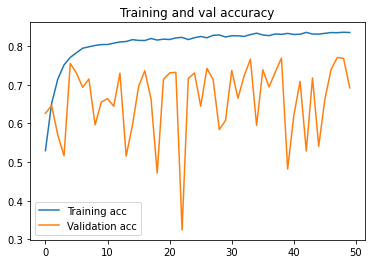

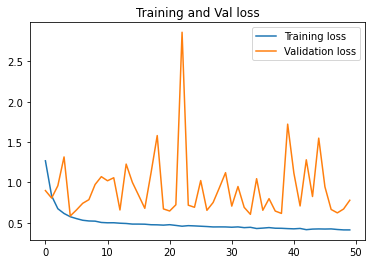

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(max(history.epoch)+1)
 
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and val accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Val loss')
plt.legend()
 
plt.show()